Initialization for environment (TODO: Init from container):

# Unit under test

A bit more complex example for simultaneous verification of the MyHDL behaviour and the simulation of the synthesized Verilog code.

In [5]:
from myhdl import *

@block
def counter_example(clk, ce, reset, dout, debug):
	counter = Signal(modbv(0)[8:])
	x = Signal(modbv()[2:])
	y = Signal(modbv()[2:])

	d = Signal(intbv(3)[2:])
	
	@always_seq(clk.posedge, reset)
	def worker():
		if ce:
			debug.next = counter[4]
			counter.next = counter + 1
			d.next = 1
		else:
			debug.next = 0
			counter.next = counter

	@always_comb
	def select():
		if counter == 14:
			x.next = d + 1
			y.next = 2
		elif counter == 118:
			x.next = d - 1
			y.next = 1
		elif counter == 22:
			x.next = 2
			y.next = 0
		else:
			if ce:
				x.next = 0
				y.next = 3
			else:
				x.next = 1
				y.next = 1

	@always_comb
	def assign():
		# dout.next = x ^ y
		dout.next = counter[:6]

	return instances()


UNIT = counter_example


Our test bench plus a clock generator and a **L**inear **F**eedback **S**hift **R**egister as external stimulus:

In [6]:

@block
def clkgen(clk, DELAY):
	@always(delay(DELAY))
	def clkgen():
		clk.next = not clk

	return instances()

@block
def lfsr8(clk, enable, reset, rval, dout):
	"""LFSR with all states"""
	v = Signal(modbv(rval)[8:])
	fb = Signal(bool())

	@always_seq(clk.posedge, reset)
	def worker():
		if enable == 1:
			v.next = concat(v[6], v[5], v[4], v[3] ^ fb, v[2] ^ fb, v[1] ^ fb, v[0], fb)

	@always_comb
	def assign():
		e = v[7:0] == 0
		fb.next = v[7] ^ e
		dout.next = v
	

	return instances()


@block
def tb_unit(uut, uut_syn, async_reset):
	mclk = Signal(bool())
	debug, debug_syn = [ Signal(bool(0)) for i in range(2) ]
	ce = Signal(bool())
	dout, do_syn = [ Signal(modbv()[8:]) for i in range(2) ]
	reset = ResetSignal(0, 1, isasync = async_reset)

	inst_clkgen = clkgen(mclk, 20)
	inst_uut = uut(mclk, ce, reset, dout, debug)
	inst_syn = uut_syn(uut, mclk, ce, reset, do_syn, debug_syn)

	r0 = Signal(modbv()[8:])

	inst_lfsr0 = lfsr8(mclk, 1, reset, 0, r0)

	@always_comb
	def assign():
		ce.next = r0[0]

	@instance
	def stimulus():
		# errcount = 0
		reset.next = 1
		yield(delay(200))
		reset.next = 0
		while 1:
			yield mclk.posedge
			print(dout, debug, " --- ", do_syn, debug_syn)
			if dout != do_syn or debug != debug_syn:
				yield mclk.posedge
				yield mclk.posedge
				yield mclk.posedge
				raise ValueError("Simulation mismatch")

	return instances()


In [7]:
from myhdl import *

import os
import subprocess

MYHDL_DIR = os.environ["HOME"] + "/src/myhdl/myhdl-yosys/"

def setupCosimulation(name, use_assert, interface):
	"""Auxiliary to return a Co-Simulation object.
	This basically creates a wrapper that calls the iverilog simulator
	to co-simulate a Verilog component against a Python test bench"""
	tb = "tb_" + name
	objfile = "%s.o" % name
	if os.path.exists(objfile):
		os.remove(objfile)
	analyze_cmd = ['iverilog', '-g2012']
	analyze_cmd += ['-o', objfile, '%s.v' % name, '%s.v' % tb]
	if use_assert:
		analyze_cmd += ['aux/assert.v']
	subprocess.call(analyze_cmd)
	simulate_cmd = ['vvp', '-m', MYHDL_DIR + '/cosimulation/icarus/myhdl.vpi']
	simulate_cmd += [ objfile ]
	c = Cosimulation(simulate_cmd, **interface)
	c.name = name
	return c


@block
def mapped_uut(which, clk, ce, reset, dout, debug):
	"Lean wrapper for cosimulation object"
	args = locals()
	name = which.func.__name__ + "_mapped"
	del args['which']

	return setupCosimulation(name, False, args)

def testbench(tb):
	"Run the specified test bench"
	tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
	tb.run_sim(20000)
	tb.quit_sim()


## Conversion and synthesis

These routines convert the MyHDL design to an internal representation and emit synthesizeable Verilog (post-synthesis).
This is later used to verify the MyHDL behaviour against the synthesized result.

CONVERT YOSYS
Setting context <myhdl.conversion.yshelper.Design object at 0x7ff419953e80>
CREATE Module: 'counter_example'
Adding module with name: counter_example_1_1_1_8_1
CONVERT_RTL instance 'counter_example' 
CONVERT_RTL tree >>>>>> 'COUNTER_EXAMPLE_WORKER' 
TRUNC: <ipython-input-5-ca77c783d2ac>:15 Implicit carry truncate: counter[8:], src[9:]
CONVERT_RTL tree >>>>>> 'COUNTER_EXAMPLE_SELECT' 
NOTICE: <ipython-input-5-ca77c783d2ac>:23 call compare attr
TRUNC: <ipython-input-5-ca77c783d2ac>:24 Implicit carry truncate: x[2:], src[3:]
NOTICE: <ipython-input-5-ca77c783d2ac>:26 call compare attr
NOTICE: <ipython-input-5-ca77c783d2ac>:29 call compare attr
WARN: <ipython-input-5-ca77c783d2ac>:29 no fullcase attr in async process
WARN: <ipython-input-5-ca77c783d2ac>:26 no fullcase attr in async process
wire x:
wire y:
CONVERT_RTL tree >>>>>> 'COUNTER_EXAMPLE_ASSIGN' 
VISIT INSTANCES
DONE instancing submodules
Display...


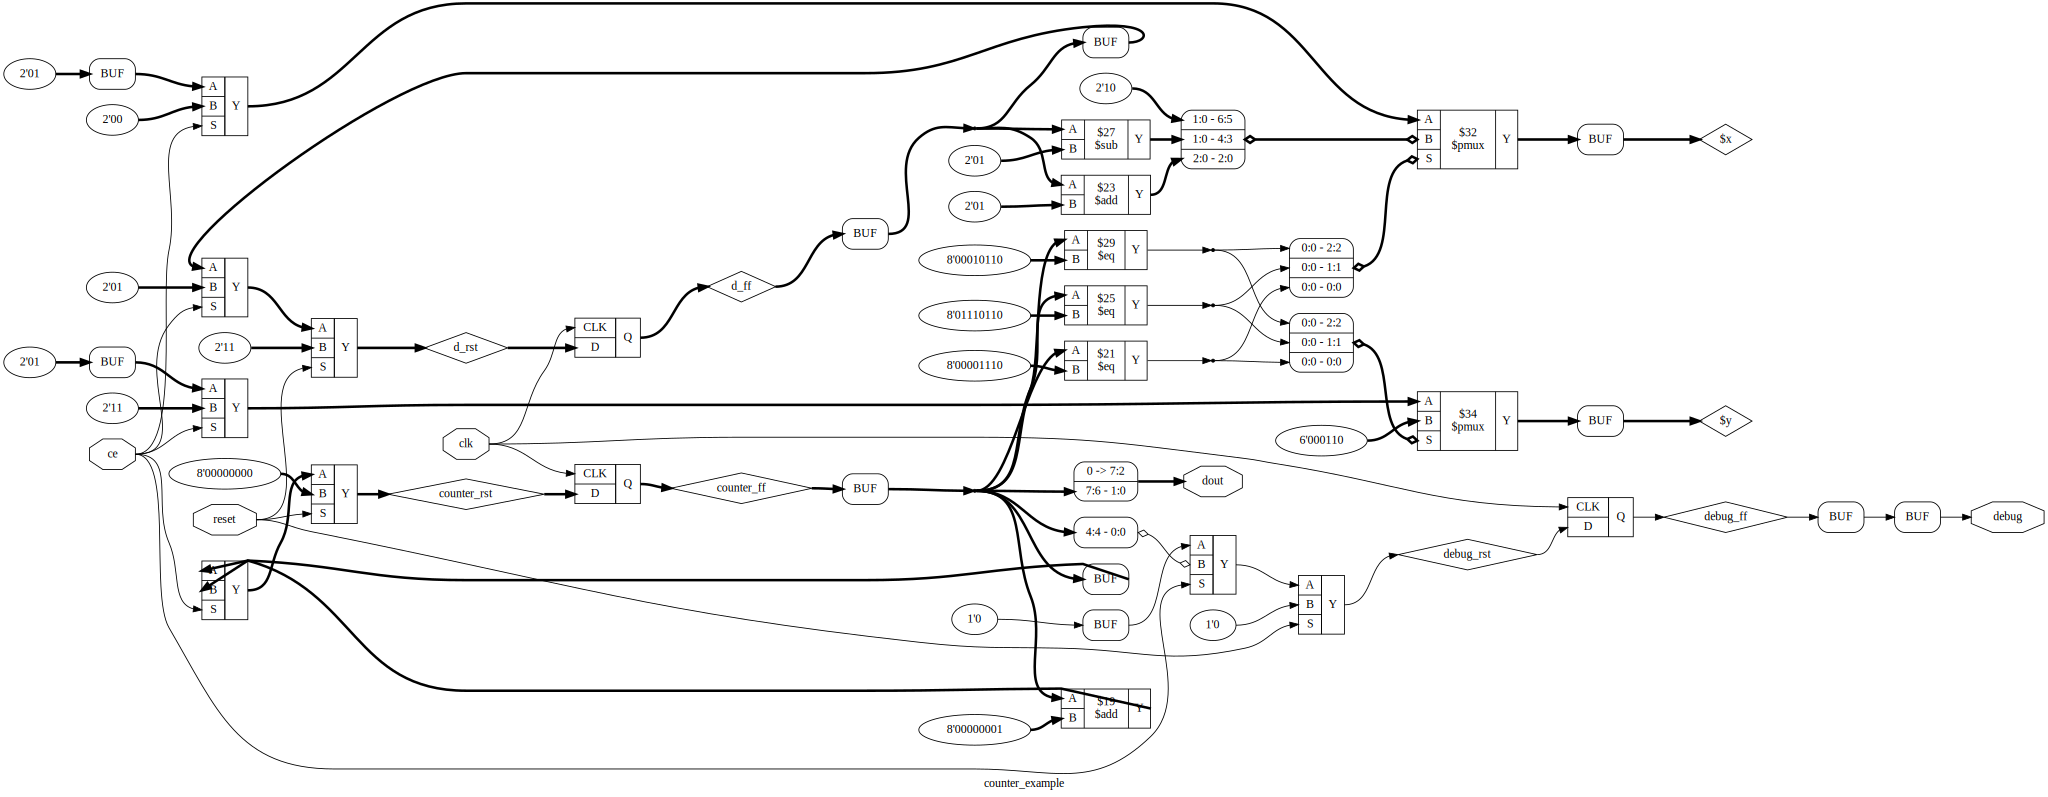

In [8]:
from myhdl.conversion import yshelper
from ys_aux import *

def convert(ent, async_reset):
	clk = Signal(bool())
	debug = Signal(bool(0))
	ce = Signal(bool())
	dout = Signal(intbv()[8:])
	reset = ResetSignal(0, 1, isasync = async_reset)

	inst = ent(clk, ce, reset, dout, debug)

	d = yshelper.Design("mem")

	print("CONVERT YOSYS")
	inst.convert("yosys_module", d, name=ent.func.__name__, trace=True)

# You might enable that for RTLIL debugging
#	d.write_ilang(ent.func.__name__)

	d.write_verilog(ent.func.__name__, True)
	return d

d = convert(UNIT, False)
display(to_svg(d))
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
from IPython.display import HTML
HTML(style)


# Running the test bench

Need to make sure a few things:

* iverilog installed
* myhdl.vpi accessible


In [9]:
!which iverilog
!ls ${HOME}/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi

/usr/bin/iverilog
/home/pyosys/src/myhdl/myhdl-yosys/cosimulation/icarus/myhdl.vpi


This finally calls the above test bench, executing the MyHDL and Verilog simulation in parallel. If a mismatch occurs, it is seen below in the output. Note that values of `True` and `1` are considered equivalent.


In [10]:
testbench(tb_unit(UNIT, mapped_uut, False))

00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 False  ---  00 False
00 True  ---  00 1
00 True  ---  00 1
00

<class 'myhdl._SuspendSimulation'>: Simulated 20000 timesteps
